In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Useful methods

In [2]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if lines is not None:
        draw_lines(line_img, lines, thickness=10)
    return line_img

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
1. Apply a distortion correction to raw images.
1. Use color transforms, gradients, etc., to create a thresholded binary image.
1. Apply a perspective transform to rectify binary image ("birds-eye view").
1. Detect lane pixels and fit to find the lane boundary.
1. Determine the curvature of the lane and vehicle position with respect to center.
1. Warp the detected lane boundaries back onto the original image.
1. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [3]:
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist

def perspective_transform(undist, nx, ny, mtx, dist):
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 150 pixels is not exact, but close enough for our purpose here

        offset = 150 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

    else:
        warped, M = None, None

    # Return the resulting image and matrix
    return warped, M

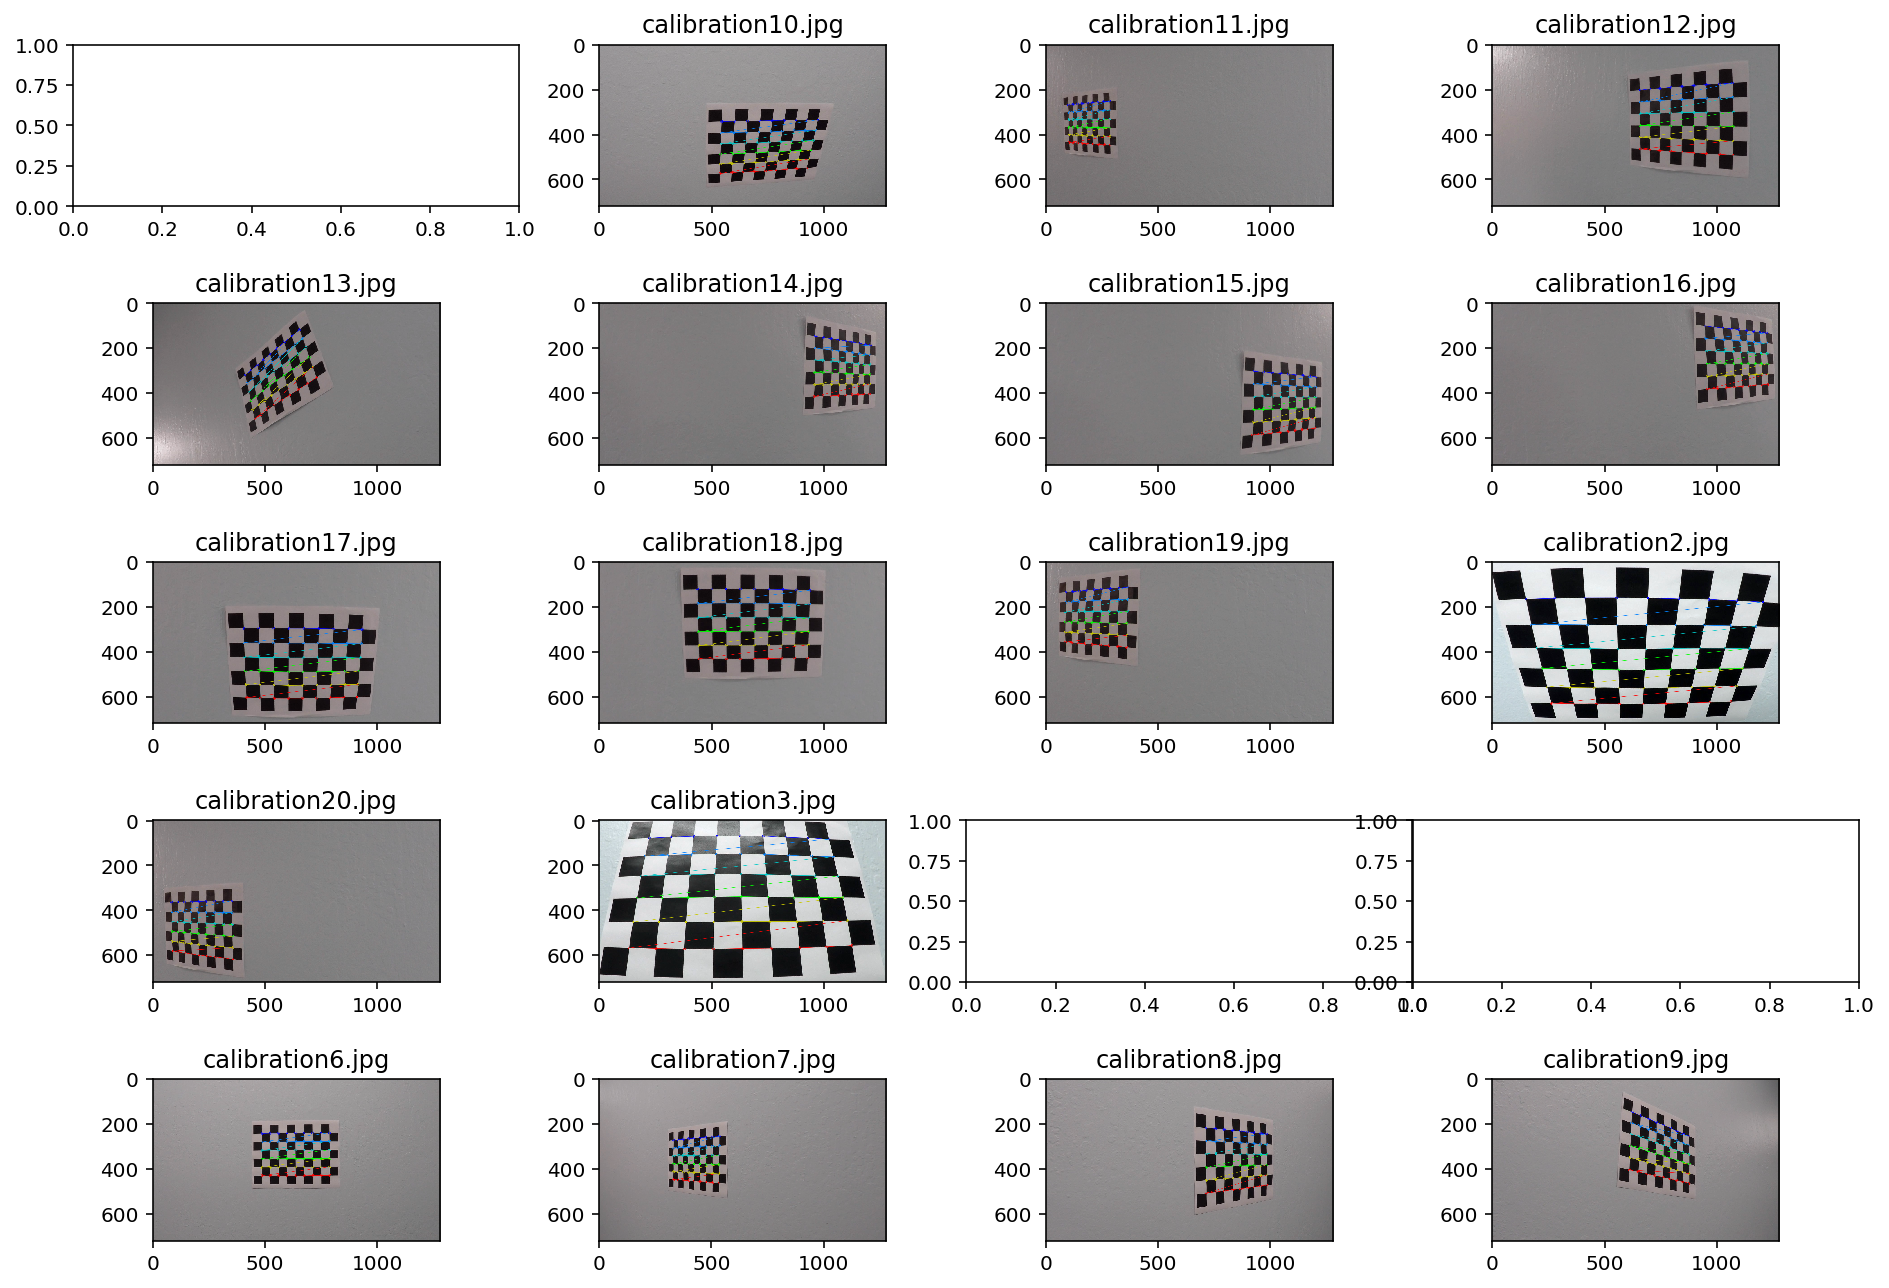

In [4]:
# cal_files = sorted(os.listdir(dir_name))
corner_size = (9,6)
nx, ny = corner_size
fail_list = []

fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .6, wspace=.001)
axs = axs.ravel()

# Directory
dir_name = "camera_cal/"
images = sorted(os.listdir(dir_name))

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

for i, fname in enumerate(images):
    img = cv2.imread(os.path.join(dir_name, fname))
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners2, ret)
        axs[i].imshow(img)
        axs[i].set_title(fname)
plt.show()

## Perspective Transform

In [5]:
height, width = 720, 1280

src = np.float32([[225, 705], [550, 482], [732, 482], [1050, 705]])
margin = 400
dst = np.float32([[width/2 - margin, height], 
                  [width/2 - margin, 0],
                  [width/2 + margin, 0], 
                  [width/2 + margin, height]])

straight_lines1.jpg


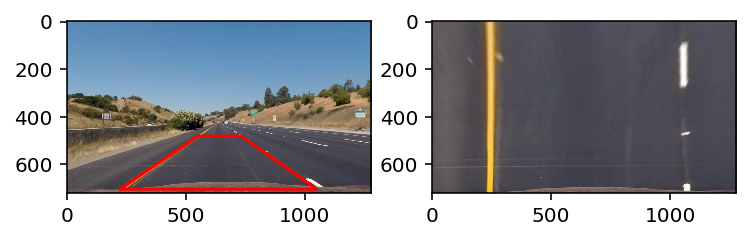

straight_lines2.jpg


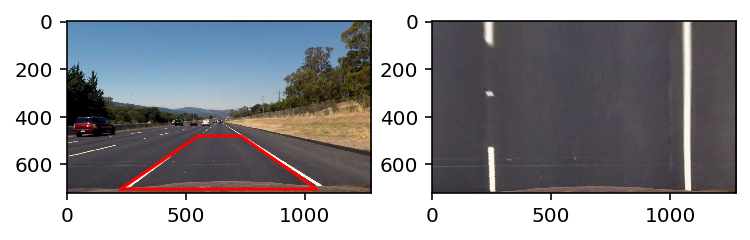

test1.jpg


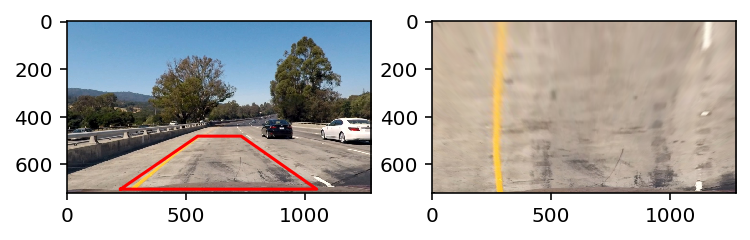

test2.jpg


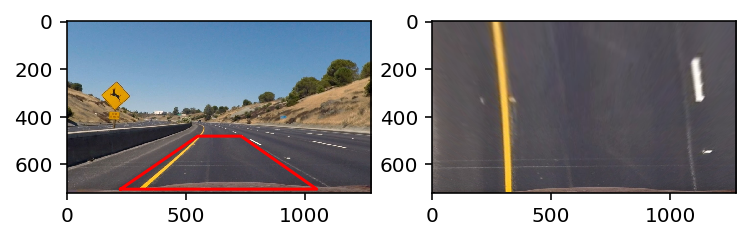

test3.jpg


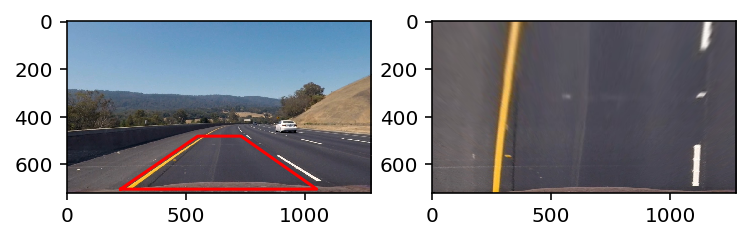

test4.jpg


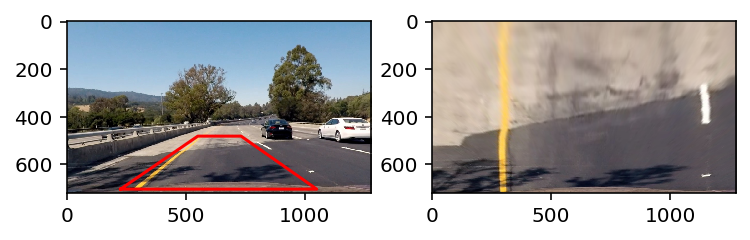

test5.jpg


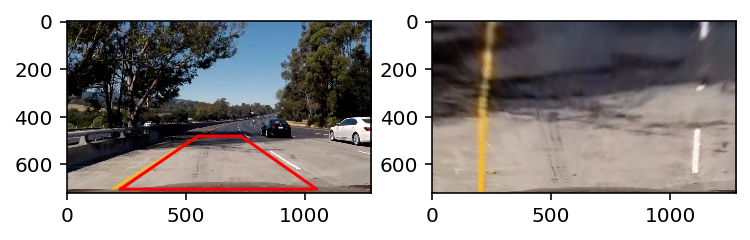

test6.jpg


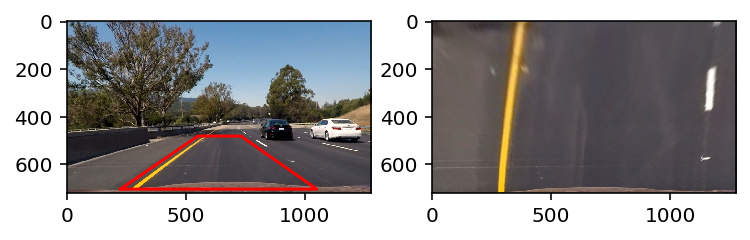

In [6]:
test_files = sorted(os.listdir("test_images/"))
# image_path = test_files[0]
for image_path in test_files:
    print(image_path)
    image = mpimg.imread('test_images/{}'.format(image_path))
    img_size = (image.shape[1], image.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)

    plt.clf()
    plt.subplot(1, 2, 1)
    plt.imshow(undist)
    plt.plot(src[[0, 1, 2, 3, 0], 0], src[[0, 1, 2, 3, 0], 1], 'r-')
    M = cv2.getPerspectiveTransform(src, dst)
    invM = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

    plt.subplot(1, 2, 2)
    plt.imshow(warped)
    plt.show()

## Thresholding

In [7]:
def abs_sobel_thresh(img, orient='x',  sobel_kernel=3, thresh=(0, 255)):
    thresh_min, thresh_max = thresh
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [8]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow', linewidth=3)
#     plt.plot(right_fitx, ploty, color='yellow', linewidth=3)

    return out_img, left_fitx, ploty, right_fitx, ploty

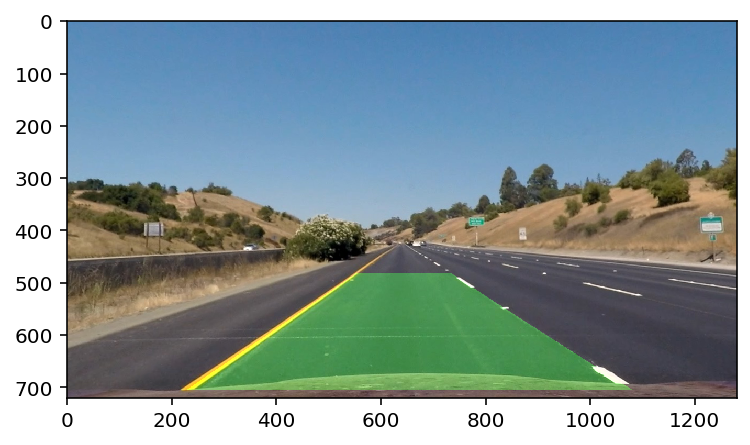

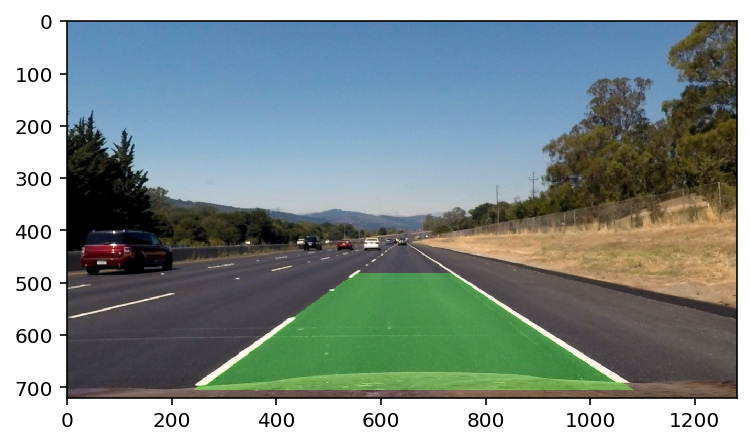

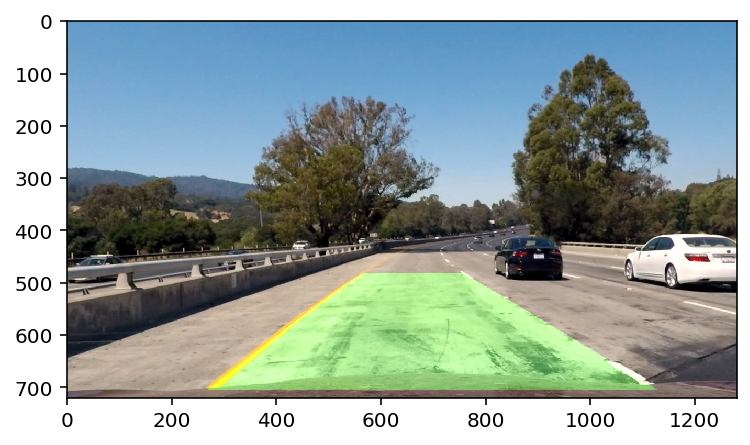

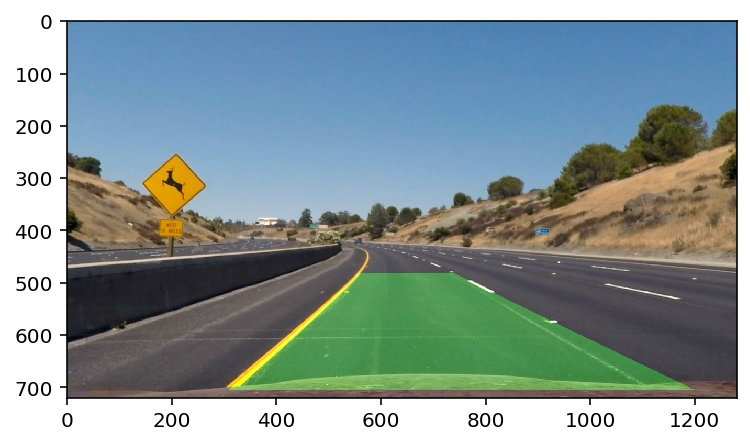

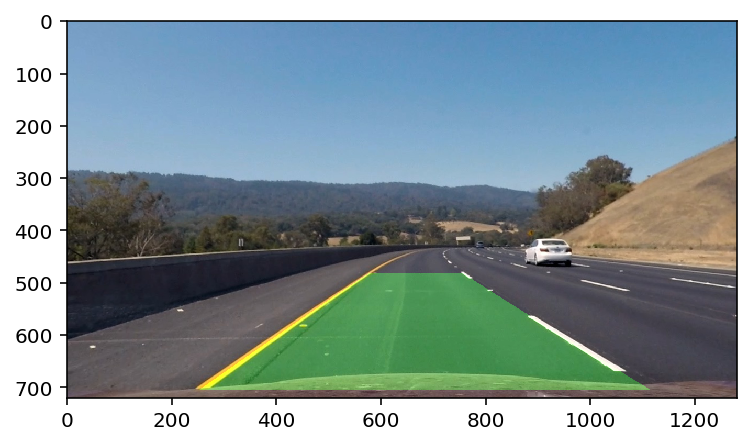

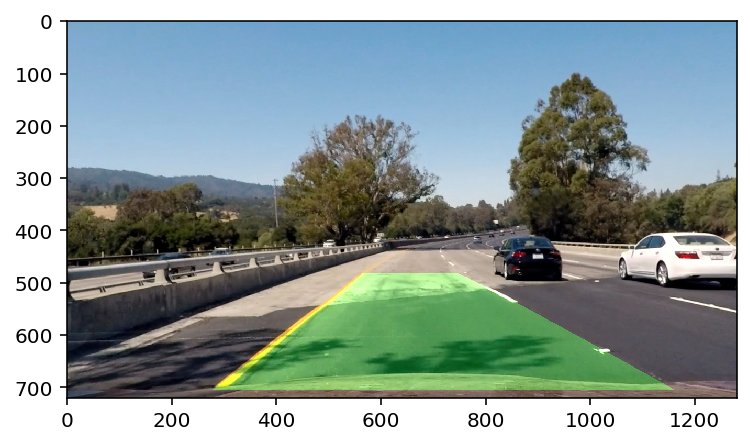

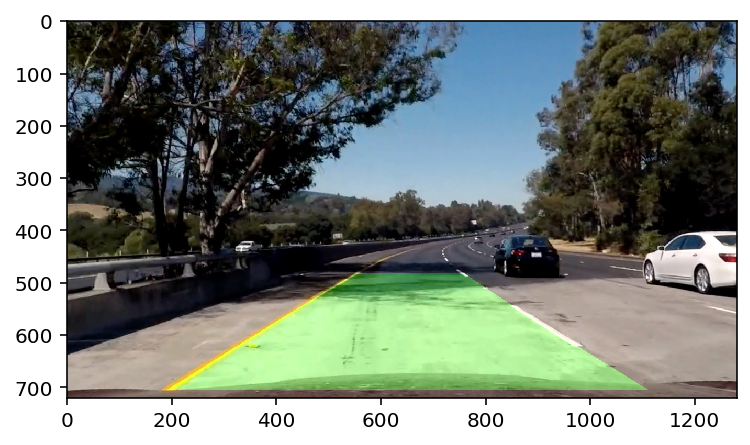

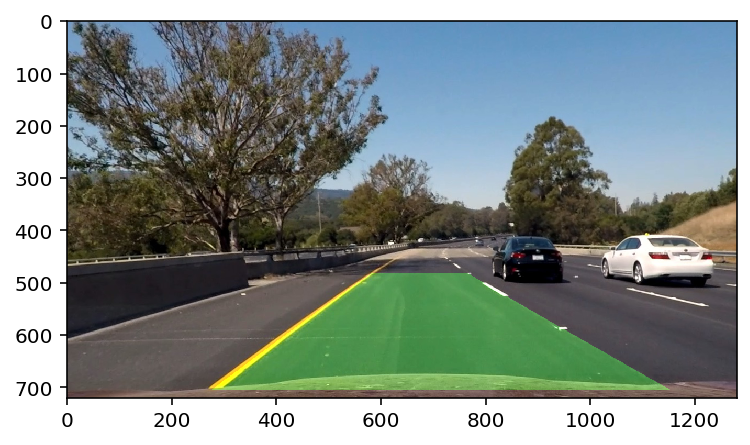

In [9]:
s_thresh=(170, 255)
sx_thresh=(20, 100)


image_path = test_files[0]
for image_path in test_files:
    image = mpimg.imread('test_images/{}'.format(image_path))
    img_size = (image.shape[1], image.shape[0])
    # Camera calibration
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)

    # Perspective Transform
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

    img_hls = cv2.cvtColor(warped, cv2.COLOR_BGR2HLS)

    l_channel = img_hls[:,:,1]
    s_channel = img_hls[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    out_img, left_fitx, ploty, right_fitx, ploty = fit_polynomial(s_binary)
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(warped).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    plt.imshow(result)
    plt.show()